<a href="https://colab.research.google.com/github/gis-up-shim/test/blob/main/FederatedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()
np.random.seed(0)

tff.federated_computation(lambda: 'Hello World')()

b'Hello World'

# Federated Learning Model Training

In [ ]:
# This function is for reading 1090 data

def conver_text_to_dataframe(path, folder_name, X_var_lst, Y_var):

    '''
    path: text file of Trian/Test dataset
    folder_name: 'Train' or 'Test'
    X_var_lst = list of independent variables (18)
    Y_var = string of depdentent variable ('selected_idx'; 0: default, 1: alternative route)

    '''
    all_files = glob.glob(path + "/*.txt")

    for i in all_files:
        client_id = i.split('/')[-1].split('.')[0].strip(folder_name)
        df = pd.read_csv(i, sep=',',names= X_var_lst)

    return df

In [ ]:
def split_train_val(df, test_size):
    '''
    Test size should determined
    '''
    Train, Val = train_test_split(df, test_size=test_size,random_state=42)

    return Train, Val

In [ ]:
import time
import calendar

def preprocess(df, drop_col_lst, dummy_col_lst):
    '''
    df: Train, Val, Test dataset (dataframe)
    drop_col_lst = list of unnecessary columns
    dummy_col_lst = lst of categorical columns

    '''
    # convert day_of_week(Mon-Sun) into integer(0-6)
    dict(zip(calendar.day_name, range(7)))
    df[['day_of_week']] = df[['day_of_week']].replace(dict(zip(calendar.day_name, range(7))))

    # drop unnecessary columns
    cleaned_df = dataframe.drop(drop_col_lst,axis = 1)

    # conver categorical variables into dummy variables
    cleaned_df = pd.get_dummies(data = cleaned_df, columns = dummy_col_lst, drop_first = True)

    return cleaned_df

In [ ]:
def normalize(df):

    labels = np.array(df.pop('selected_idx'))
    features = np.array(df)

    #Standardization
    scaler = StandardScaler()

    #Standardize only continuous features
    features_cont = scaler.fit_transform(features[:,0:13])
    #Concatenate standarized features and categorical features
    features = np.concatenate((features_cont, np.array(features[:,14:])), axis=1)

    return features, labels

In [ ]:
def make_driver_data(df):
    '''
    Transforming dataframe into tensor sliced client data to input federated learning framework
    df: Train, Test, Val
    '''
    drivers_id = list(df.num_id) #list of driver id
    client_data = collections.OrderedDict() #creating empty Dictrionary

    for i in drivers_id:

        client_df = df.loc[df.num_id == i]

        features, labels = Normalize(client_df)
        data = collections.OrderedDict((('label', labels), ('predictors', features)))

        client_data[i] = data

    tensor_client_data = tff.simulation.FromTensorSlicesClientData(client_data)

    return tensor_client_data

In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = 100
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER=10

def federated_preprocess(dataset):

    def batch_format_fn(element):

        return collections.OrderedDict(
        x=tf.reshape(element['predictors'], [-1, 45]),
        y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [ ]:
def make_federated_data(client_data, client_ids):
    return [
      federated_preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [ ]:
def create_keras_model(output_bias=None):
    '''
    Creating Keras model
    input_shape will be the number of features
    '''
        return tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu',input_shape=(45,)),
#             tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation ='relu'),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(16, activation ='relu'),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(5, activation ='relu'),
#             tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
])

In [ ]:
def model_fn():
    '''
    federated learning using keras model
    loss function: Binary Cross entropy (y variable is binary)
    '''
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),

      metrics=[tf.keras.metrics.BinaryAccuracy()])

**Federated Learning Traning**  
- optimizer: Adam
- Communication rounds: 30
- Selected driver per round: 600  
all of paramters can be tuned for optimization

In [ ]:

import nest_asyncio
nest_asyncio.apply()

train_metrics_list = []
eval_metrics_list = []

federated_average = tff.learning.build_federated_averaging_process(model_fn,
                                                                   client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
                                                                    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.1))
federated_eval = tff.learning.build_federated_evaluation(model_fn)

state = federated_average.initialize()

NUM_ROUNDS = 30 #communication rounds

for num_round in range(1, NUM_ROUNDS):
    participating_clients = np.random.choice(total_client_train.client_ids, size=600) # the number of randomly selected driver.


  # Run a training pass
    #federated train dataset with selected clients
    client_train_datasets = make_federated_data(total_client_train, participating_clients)
    state, train_metrics = federated_average.next(state, client_train_datasets)
    train_metrics_list.append(train_metrics)

    print('round {:2d}, train_metrics={}'.format(num_round, train_metrics))


  # Run an evaluation pass
    #federated test dataset with selected clients
    client_eval_datasets =  make_federated_data(total_client_val, participating_clients)
    eval_metrics = federated_eval(state.model, client_eval_datasets)
    eval_metrics_list.append(eval_metrics)
    print('round {:2d}, eval_metrics={}'.format(num_round, eval_metrics))

In [ ]:
def performance_plot_with_metrics(train_metrics_list, eval_metrics_list):
    '''
    Drawing a plot with train/evaluation values from FL training
    '''
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    for i in range(len(train_metrics_list)):
        train_acc_list.append(train_metrics_list[i][0])
        val_acc_list.append(eval_metrics_list[i][0])

        train_loss_list.append(train_metrics_list[i][1])
        val_loss_list.append(eval_metrics_list[i][1])

    # list all data in history
    #print(history.history.keys())
    # summarize history for accuracy
    plt.plot(train_acc_list, color = 'grey')
    plt.plot(val_acc_list,'--',color = 'grey')
    #plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('communication round')
    plt.ylim((0.2,0.8))
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(train_loss_list, color = 'grey')
    plt.plot(val_loss_list,'--', color = 'grey')
    #plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('communication round')
    plt.ylim((0.5,1.75))
    plt.legend(['train', 'val'], loc='upper right')
    plt.rcParams.update({'font.size': 17})

    return plt.show()


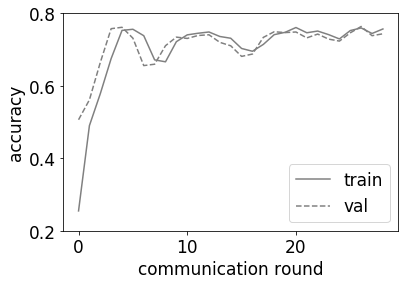

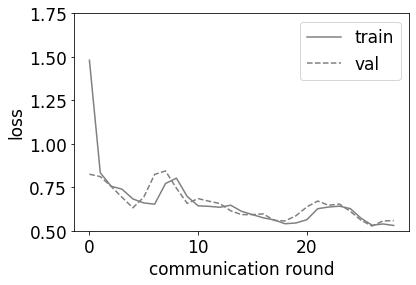

In [ ]:
performance_plot_with_metrics(train_metrics_list, eval_metrics_list)

# Centralized Model Training

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def conver_text_to_dataframe(path, folder_name, X_var_lst, Y_var):

    '''
    path: text file of Trian/Test dataset
    folder_name: 'Train' or 'Test'
    X_var_lst = list of independent variables (18)
    Y_var = string of depdentent variable ('selected_idx'; 0: default, 1: alternative route)

    '''
    all_files = glob.glob(path + "/*.txt")

    for i in all_files:
        client_id = i.split('/')[-1].split('.')[0].strip(folder_name)
        df = pd.read_csv(i, sep=',',names= X_var_lst)

    return df

In [ ]:
def split_train_val(df):

    Train, Val = train_test_split(df, test_size=0.2,random_state=42)

    return Train, Val

In [ ]:
import time
import calendar

def preprocess(df, drop_col_lst, dummy_col_lst):
    '''
    df: Train, Val, Test dataset (dataframe)
    drop_col_lst = list of unnecessary columns
    dummy_col_lst = lst of categorical columns

    '''
    # convert day_of_week(Mon-Sun) into integer(0-6)
    dict(zip(calendar.day_name, range(7)))
    df[['day_of_week']] = df[['day_of_week']].replace(dict(zip(calendar.day_name, range(7))))

    # drop unnecessary columns
    cleaned_df = dataframe.drop(drop_col_lst,axis = 1)

    # conver categorical variables into dummy variables
    cleaned_df = pd.get_dummies(data = cleaned_df, columns = dummy_col_lst, drop_first = True)

    return cleaned_df

In [ ]:
def normalize(df):

    # Normalize
    labels = np.array(df.pop('selected_idx'))
    features = np.array(df)

    scaler = StandardScaler()
    features_cont = scaler.fit_transform(features[:,0:13])
    features = np.concatenate((features_cont, np.array(features[:,14:])), axis=1)

    return features, labels

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
#            keras.layers.Dense(16, activation ='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3), #optimizer: Adam (with learning rate = 0.001)
      loss=keras.losses.BinaryCrossentropy(), # loss function: Binary Corss Entropy (y variable is binary)
      metrics=metrics)

    return model

In [ ]:
EPOCHS = 50
BATCH_SIZE = 200

# early stopper to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                736       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = make_model()
#model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/50
8628/8628 [==============================] - 32s 4ms/step - loss: 0.5064 - tp: 53294.0000 - fp: 54992.0000 - tn: 1247923.0000 - fn: 369346.0000 - accuracy: 0.7541 - precision: 0.4922 - recall: 0.1261 - auc: 0.7105 - val_loss: 0.5013 - val_tp: 14514.0000 - val_fp: 13682.0000 - val_tn: 312110.0000 - val_fn: 91083.0000 - val_accuracy: 0.7571 - val_precision: 0.5148 - val_recall: 0.1374 - val_auc: 0.7182
Epoch 2/50
8628/8628 [==============================] - 32s 4ms/step - loss: 0.5003 - tp: 54178.0000 - fp: 50306.0000 - tn: 1252609.0000 - fn: 368462.0000 - accuracy: 0.7573 - precision: 0.5185 - recall: 0.1282 - auc: 0.7202 - val_loss: 0.5001 - val_tp: 15478.0000 - val_fp: 14535.0000 - val_tn: 311257.0000 - val_fn: 90119.0000 - val_accuracy: 0.7574 - val_precision: 0.5157 - val_recall: 0.1466 - val_auc: 0.7201
Epoch 3/50
8628/8628 [==============================] - 32s 4ms/step - loss: 0.4993 - tp: 53843.0000 - fp: 49786.0000 - tn: 1253129.0000 - fn: 368797.0000 - accuracy: 0.7

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    '''
    plot confusion matrix
    input: lables and predicted value from model training
    '''
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

4623/4623 [==============================] - 13s 3ms/step - loss: 0.4973 - tp: 30802.0000 - fp: 28857.0000 - tn: 669690.0000 - fn: 195056.0000 - accuracy: 0.7578 - precision: 0.5163 - recall: 0.1364 - auc: 0.7244
loss :  0.49729329347610474
tp :  30802.0
fp :  28857.0
tn :  669690.0
fn :  195056.0
accuracy :  0.7577760815620422
precision :  0.5163009762763977
recall :  0.1363777220249176
auc :  0.724433183670044

Legitimate Transactions Detected (True Negatives):  671432
Legitimate Transactions Incorrectly Detected (False Positives):  27115
Fraudulent Transactions Missed (False Negatives):  196006
Fraudulent Transactions Detected (True Positives):  29852
Total Fraudulent Transactions:  225858


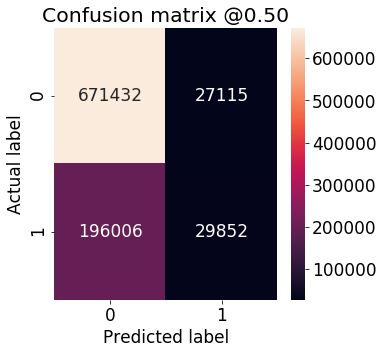

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=1)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

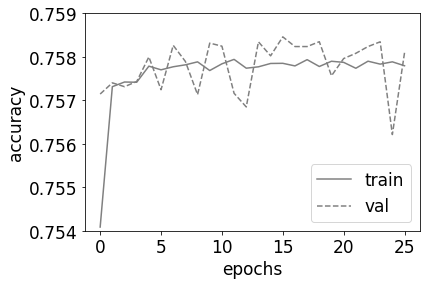

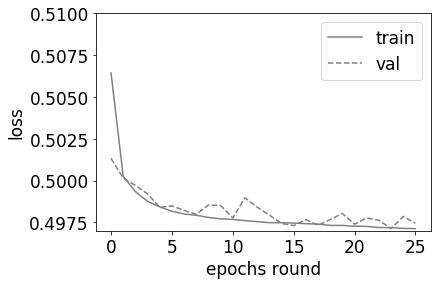

In [ ]:
# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(baseline_history.history['accuracy'], color = 'grey')
plt.plot(baseline_history.history['val_accuracy'],'--',color = 'grey')
#plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.ylim((0.754,0.759))
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(baseline_history.history['loss'], color = 'grey')
plt.plot(baseline_history.history['val_loss'],'--', color = 'grey')
#plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs round')
plt.ylim((0.497,0.51))
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.rcParams.update({'font.size': 17})